# Gaussian Process Regression Testing

In this notebook I want to compare python implementations of Gaussian Process regression in 3D with the Scalismo library written in Scala

Two methods will be used: 
- Sklearn https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html 
- GPyTorch https://docs.gpytorch.ai/en/stable/index.html 

While the Sklearn implementation is simpler (and maybe more flexible), the GPy

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
import time

In [ ]:
from typing import Union
import pytest
import ipytest
import torch 

ipytest.autoconfig(raise_on_error=True)

def vectorize(data: Union[np.ndarray, torch.Tensor]) -> Union[np.ndarray, torch.Tensor]:
  if isinstance(data, np.ndarray):
      return data.flatten()
  elif isinstance(data, torch.Tensor):
      return data.view(-1)
  else:
      raise TypeError("Input must be either a numpy array or a PyTorch tensor")

def unvectorize(data: Union[np.ndarray, torch.Tensor], dim: int) -> Union[np.ndarray, torch.Tensor]:
  if isinstance(data, np.ndarray):
      n = int(len(data)/dim)
      return data.reshape((n, dim))
  elif isinstance(data, torch.Tensor):
      n = int(data.numel()/dim)
      return data.view(n, dim)
  else:
      raise TypeError("Input must be either a numpy array or a PyTorch tensor")


In [ ]:
%%ipytest -s
# | code-fold: true

def test_vectorize():
    input_data = torch.tensor([[1, 2, 3], [4, 5, 6]])
    expected_output = torch.tensor([1, 2, 3, 4, 5, 6])
    assert torch.all(vectorize(input_data).eq(expected_output))
    assert np.array_equal(vectorize(input_data).numpy(), expected_output.numpy())

def test_unvectorize():
    input_data = torch.tensor([1, 2, 3, 4, 5, 6])
    expected_output = torch.tensor([[1, 2, 3], [4, 5, 6]])
    assert torch.all(unvectorize(input_data, 3).eq(expected_output))
    assert np.array_equal(unvectorize(input_data.numpy(), 3), expected_output.numpy())

def vectorize_unvectorize_roundtrip(data: Union[np.ndarray, torch.Tensor]) -> bool:
    vectorized = vectorize(data)
    unvectorized = unvectorize(vectorized, data.shape[1])
    if isinstance(data, torch.Tensor):
        return torch.all(data.eq(unvectorized))
    else:
        return np.array_equal(data, unvectorized)

def test_vectorize_unvectorize_roundtrip():
    input_data = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])
    assert vectorize_unvectorize_roundtrip(input_data)
    assert vectorize_unvectorize_roundtrip(input_data.numpy())

    random_data = torch.rand(10, 5)
    assert vectorize_unvectorize_roundtrip(random_data)
    assert vectorize_unvectorize_roundtrip(random_data.numpy())

# Sklearn example in 3D - i.e. no vetorization of data

In [4]:
plot_data = True
board_size = 5000
if plot_data:
    board_size = 20
num_points = board_size*board_size

noise_levels = [1.0]
if plot_data:
    noise_levels = [1.0, 2.0, 5.0]

i, j = np.indices((board_size, board_size))
points = np.stack((i, j, np.ones_like(i) * board_size/2.0), axis=-1).reshape(-1, 3)

print(f"Total number of points: {int(points.size/3):,}")

def plot_3d(ax, X, Y, Z, title):
    # zs = np.zeros(num_points) 
    # dx = np.ones(num_points) 
    # dy = np.ones(num_points) 
    # ax.bar3d(X, Y, zs, dx, dy, Z)
    ax.scatter(X, Y, Z)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([0, board_size])
    ax.set_ylim([0, board_size])
    ax.set_zlim([0, board_size])

pos_points = [points[0], points[int(board_size**2/2-board_size/2)]]

deformation_vector = np.array([0, 0, board_size])
deformation_point_0 = np.array(pos_points[0])
deformation_point_1 = np.array(pos_points[1])

X = np.array([deformation_point_0, deformation_point_1])
y = np.array([deformation_vector, deformation_vector])

kernel = RBF(length_scale=1.0)

Total number of points: 400


Execution time posterior: 0.00s with noise: 1.0
Execution time adding: 0.00s with noise: 1.0
Execution time posterior: 0.00s with noise: 2.0
Execution time adding: 0.00s with noise: 2.0
Execution time posterior: 0.00s with noise: 5.0
Execution time adding: 0.00s with noise: 5.0


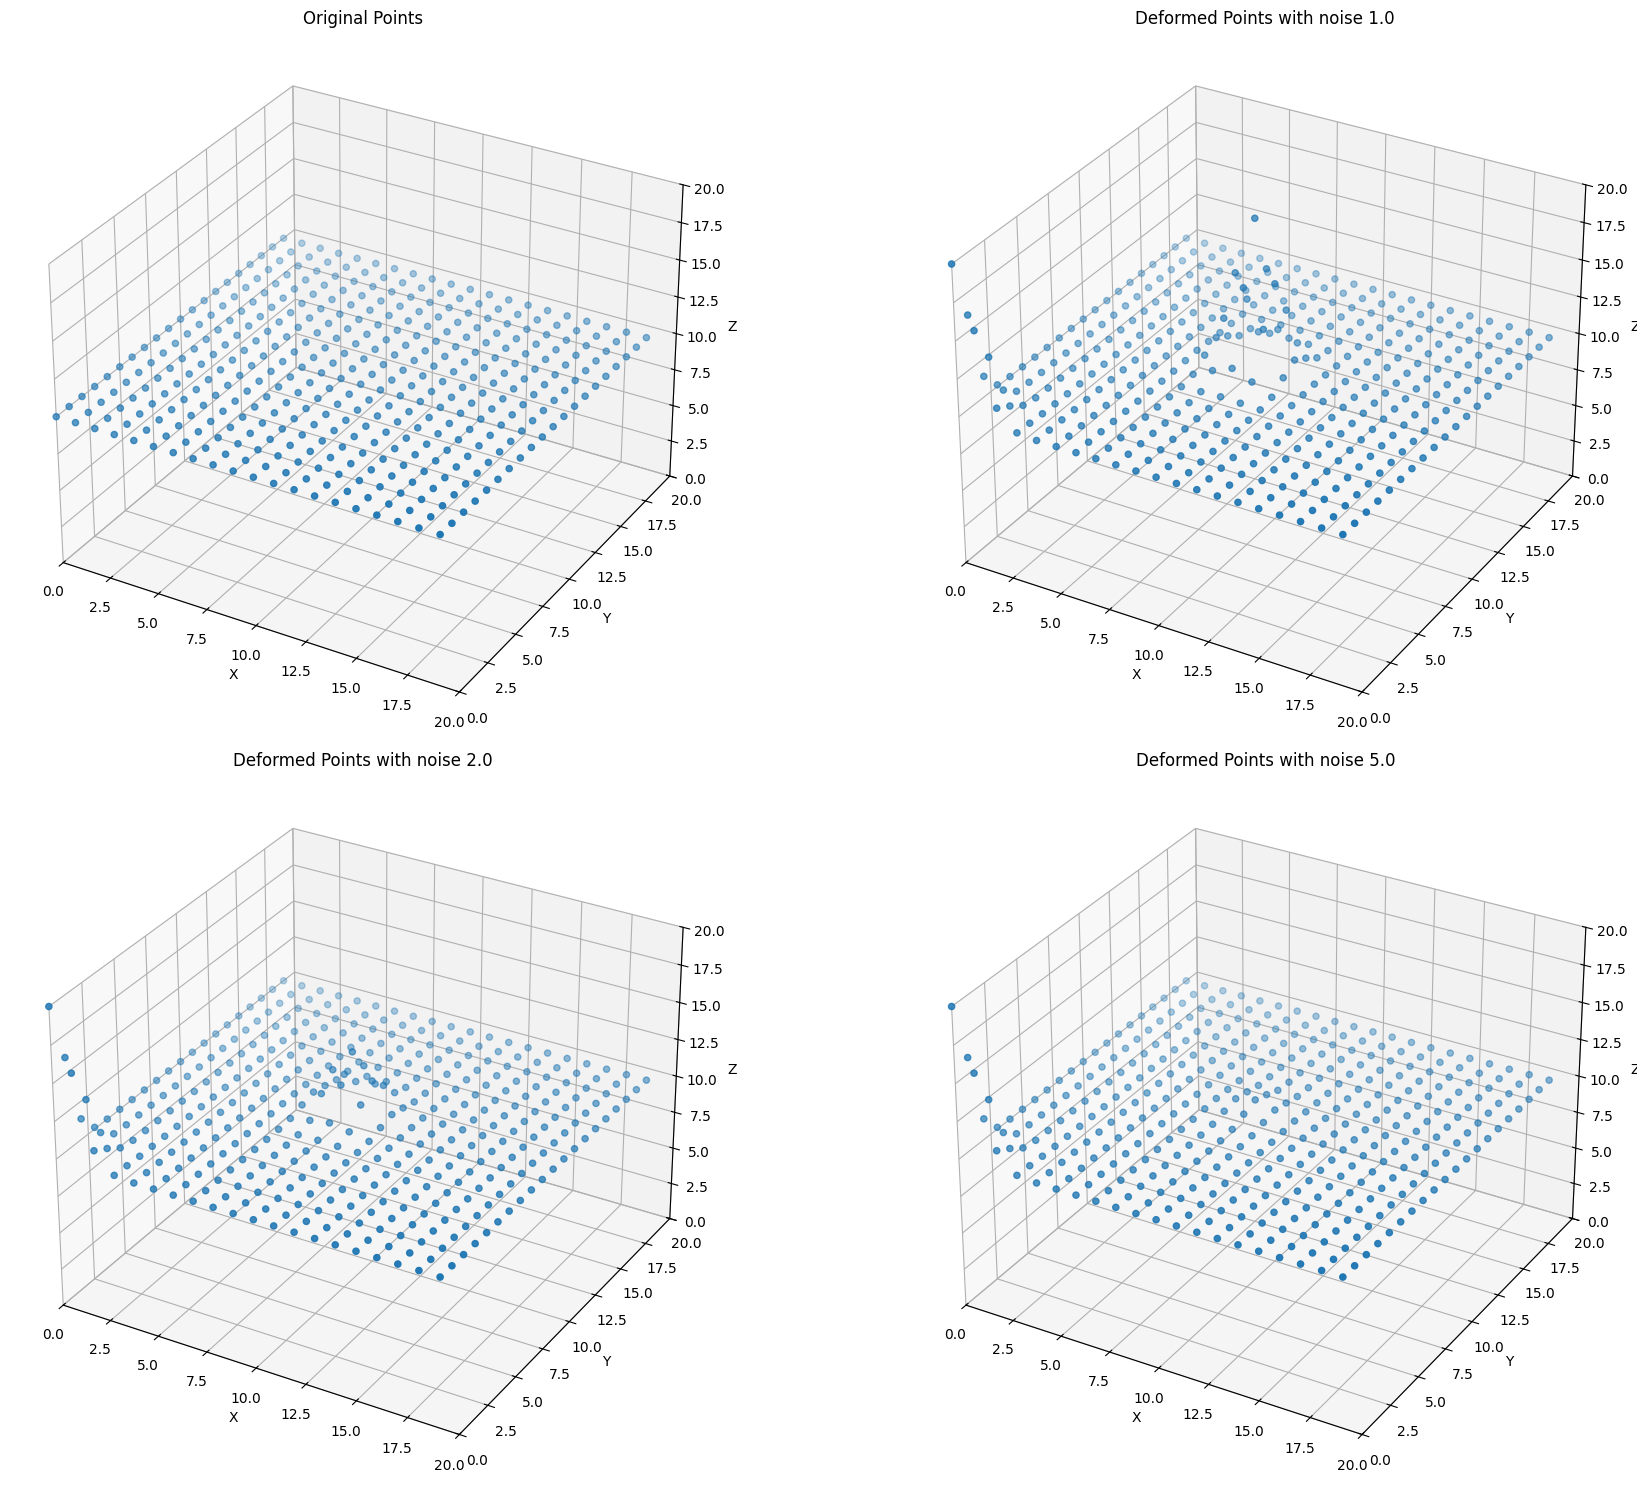

In [5]:
if plot_data:
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(2,2,1, projection='3d')
    plot_3d(ax, points[:, 0], points[:, 1], points[:, 2], "Original Points")

for i, noise in enumerate(noise_levels):

    gpr = GaussianProcessRegressor(kernel=kernel, alpha=np.array([1.0, noise**2]))

    start_time = time.time()

    gpr.fit(X, y)
    predicted_deformation_field = gpr.predict(points)
    
    mid_time = time.time()
    new_points = points + predicted_deformation_field

    end_time = time.time()
    execution_time_pos = mid_time - start_time
    execution_time_add = end_time - mid_time
    print(f"Execution time posterior: {execution_time_pos:.2f}s with noise: {noise}")
    print(f"Execution time adding: {execution_time_add:.2f}s with noise: {noise}")

    if plot_data:
        ax = fig.add_subplot(2,2,i+2, projection='3d')
        plot_3d(ax, new_points[:, 0], new_points[:, 1], new_points[:, 2], f"Deformed Points with noise {noise}")

if plot_data:
    plt.tight_layout()
    plt.show()

# Sklearn example in 3D by vectorizing data
- NOT Working as expected.
## This output should be the same as in the above example!

/opt/miniconda3/envs/mynotebooks/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Execution time posterior: 0.00s with noise: 1.0
Execution time adding: 0.00s with noise: 1.0
Execution time posterior: 0.00s with noise: 2.0
Execution time adding: 0.00s with noise: 2.0
Execution time posterior: 0.00s with noise: 5.0
Execution time adding: 0.00s with noise: 5.0


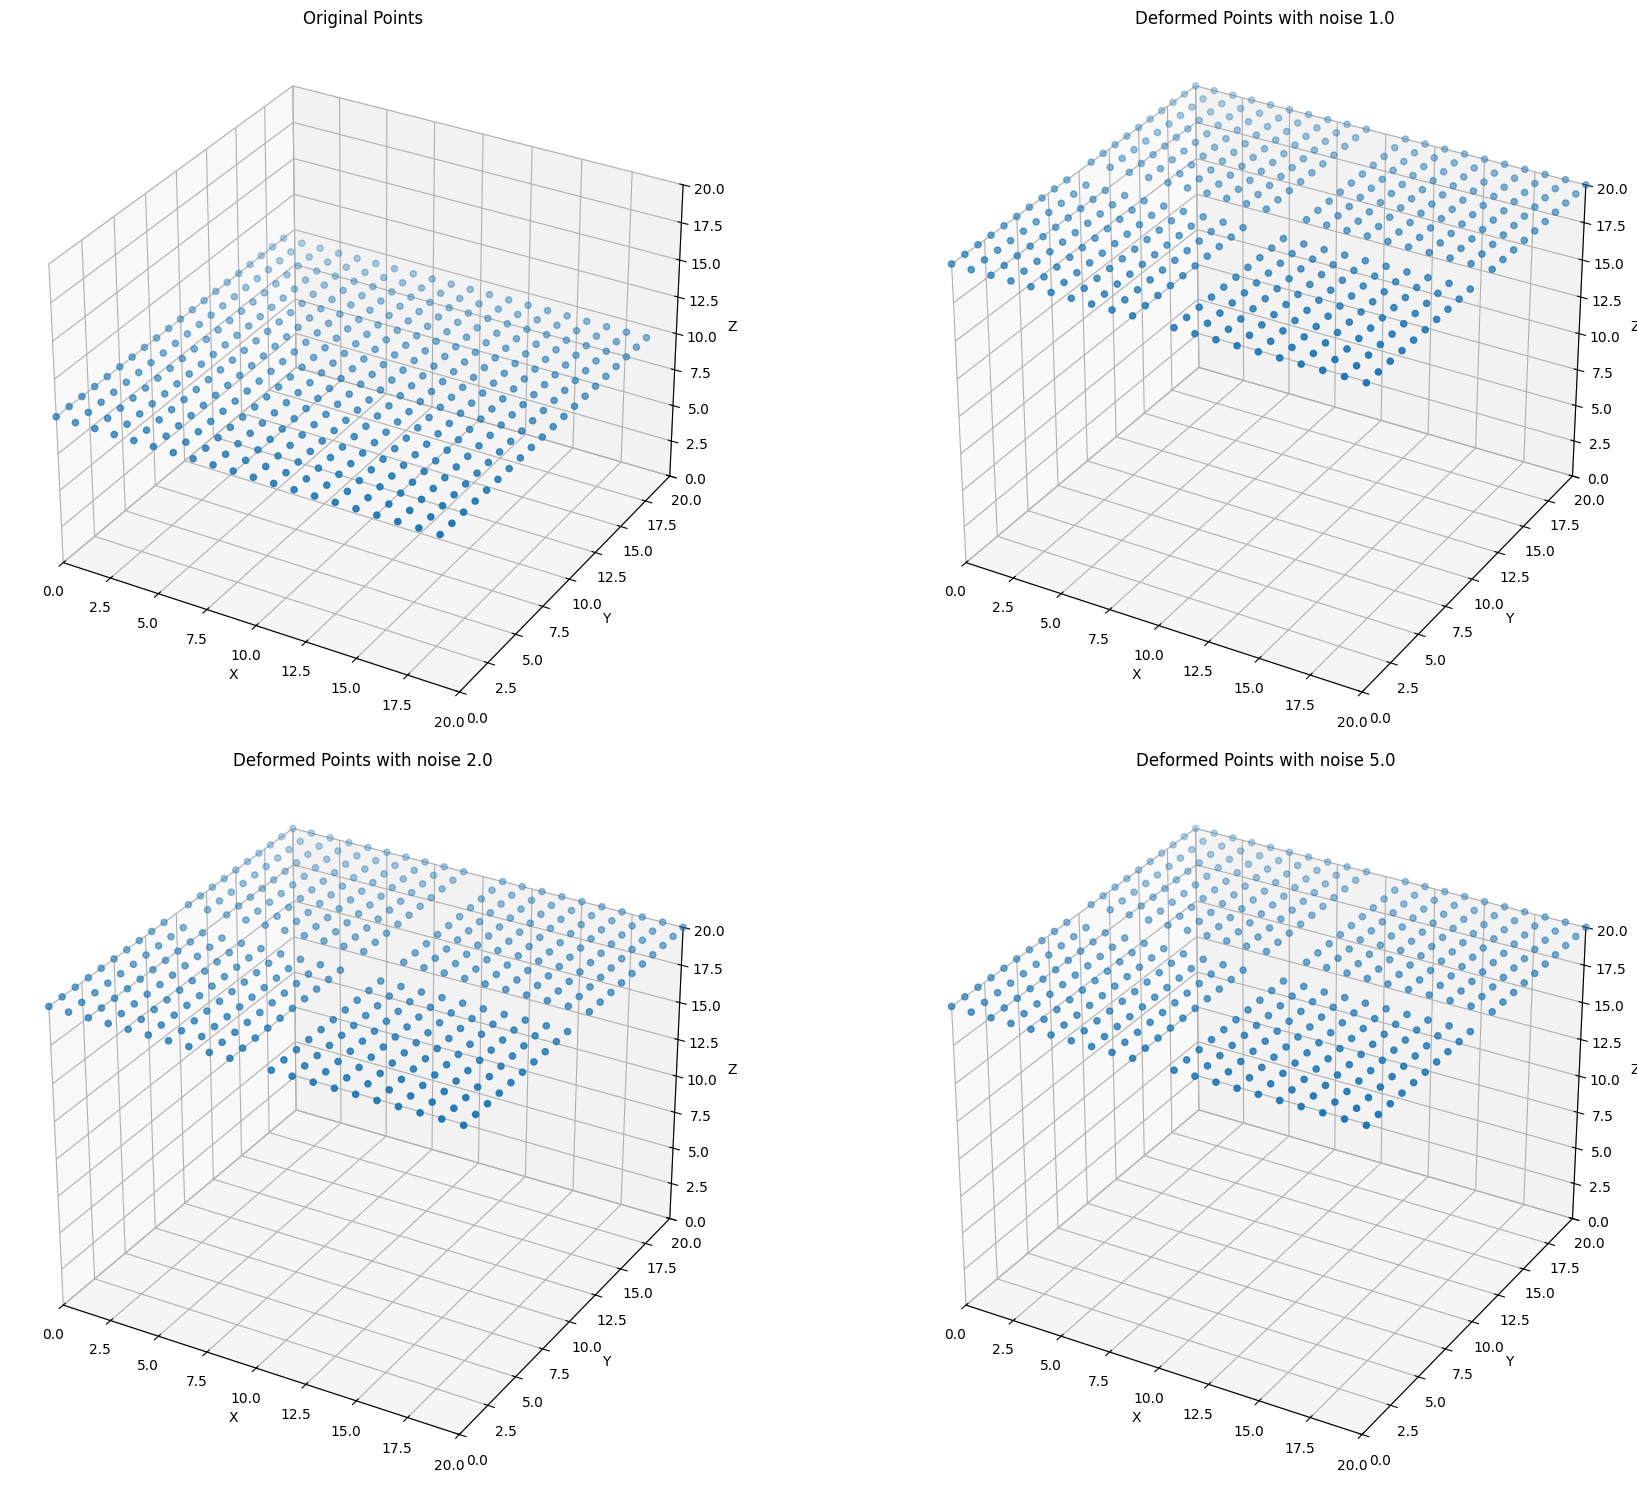

In [6]:
if plot_data:
  fig = plt.figure(figsize=(20, 15))
  ax = fig.add_subplot(2,2,1, projection='3d')
  plot_3d(ax, points[:, 0], points[:, 1], points[:, 2], "Original Points")

# Vectorize the input data
vectorized_points = vectorize(points)
vectorized_X = vectorize(X)
vectorized_y = vectorize(y)

for i, noise in enumerate(noise_levels):
  gpr = GaussianProcessRegressor(kernel=kernel, alpha=np.array([1.0, 1.0, 1.0, noise**2, noise**2, noise**2]))

  start_time = time.time()

  # Fit the model with vectorized data
  gpr.fit(vectorized_X.reshape(-1, 1), vectorized_y.reshape(-1, 1))

  # Predict deformations for all points
  vectorized_predicted_deformation_field = gpr.predict(vectorized_points.reshape(-1, 1))
  
  mid_time = time.time()

  # Reshape the predicted deformations back to 3D
  predicted_deformation_field = unvectorize(vectorized_predicted_deformation_field, 3)

  # Apply the deformations
  new_points = points + predicted_deformation_field

  end_time = time.time()
  execution_time_pos = mid_time - start_time
  execution_time_add = end_time - mid_time
  print(f"Execution time posterior: {execution_time_pos:.2f}s with noise: {noise}")
  print(f"Execution time adding: {execution_time_add:.2f}s with noise: {noise}")

  if plot_data:
      ax = fig.add_subplot(2,2,i+2, projection='3d')
      plot_3d(ax, new_points[:, 0], new_points[:, 1], new_points[:, 2], f"Deformed Points with noise {noise}")

if plot_data:
  plt.tight_layout()
  plt.show()

# Simple 1D example with variable noise terms in Gpytorch
- Using Multitask model but with num_task=1 (such that it is similar to using a standard MultivariateNormal

In [ ]:
import torch
import gpytorch
from tqdm import tqdm
from matplotlib import pyplot as plt

# train_x = torch.linspace(0, 1, 100)
# train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)
train_x = torch.tensor([0.01, 0.3, 0.6, 0.99]).unsqueeze(-1)
train_y = torch.tensor([1.0, -2.0, 2.0, -4.0]).unsqueeze(-1)

# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.kernel = gpytorch.kernels.RBFKernel()
#         self.kernel.lengthscale = 1.0
#         self.mean_module = gpytorch.means.ZeroMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(self.kernel)
#         self.covar_module.outputscale = 1.0
    
#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
class MultitaskExactGPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
      super(MultitaskExactGPModel, self).__init__(train_x, train_y, likelihood)
      
      self.num_tasks = 1
      
      self.base_kernel = gpytorch.kernels.RBFKernel()
      self.base_kernel.lengthscale = 1.0
      
      self.covar_module = gpytorch.kernels.MultitaskKernel(
          self.base_kernel, num_tasks=self.num_tasks, rank=1
      )
      self.covar_module.outputscale = 1.0
      
      self.mean_module = gpytorch.means.MultitaskMean(
          gpytorch.means.ZeroMean(), num_tasks=self.num_tasks
      )

  def forward(self, x):
      mean_x = self.mean_module(x)
      covar_x = self.covar_module(x)
      return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.tensor([0.1, 0.0001, 5.0, 0.001]), learn_additional_noise=False)
model = MultitaskExactGPModel(train_x, train_y, likelihood)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50

pbar = tqdm(range(training_iter), desc="Training")

model.train()
likelihood.train()
for _ in pbar:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    pbar.set_description(f"Loss: {loss.item():.3f}, Noise: {noise}")
    optimizer.step()

In [ ]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(12, 8))

    lower, upper = observed_pred.confidence_region()
    lower = lower.squeeze().numpy()
    upper = upper.squeeze().numpy()
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
    ax.set_ylim([-5, 5])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])


# 3D example with 2D board in Gpytorch
 - Noise term not working
 - Need to update to use vectorized data

In [ ]:
import torch
import gpytorch
from tqdm.notebook import tqdm
from gpytorch.likelihoods import _MultitaskGaussianLikelihoodBase

# GPYTORCH paper from 2018 (NeurIPS) https://arxiv.org/pdf/1809.11165 

print("Using PyTorch", torch.__version__, "and GPyTorch", gpytorch.__version__)

class MultitaskGPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
      super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
      self.mean_module = gpytorch.means.MultitaskMean(
          gpytorch.means.ZeroMean(), num_tasks=3
      )
      self.covar_module = gpytorch.kernels.MultitaskKernel(
          gpytorch.kernels.RBFKernel(), num_tasks=3, rank=0
      )

  def forward(self, x):
      mean_x = self.mean_module(x)
      covar_x = self.covar_module(x)
      return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert numpy arrays to PyTorch tensors
points_tensor = torch.tensor(points, dtype=torch.float32).to(device)

In [ ]:
import gpytorch.constraints


if plot_data:
  fig = plt.figure(figsize=(20, 15))
  ax = fig.add_subplot(2,2,1, projection='3d')
  plot_3d(ax, points[:, 0], points[:, 1], points[:, 2], "Original Points")

deformation_vector = torch.tensor([0, 0, board_size], dtype=torch.float32).to(device)
deformation_point_0 = torch.tensor(pos_points[0], dtype=torch.float32).to(device)
deformation_point_1 = torch.tensor(pos_points[1], dtype=torch.float32).to(device)

for i, noise in enumerate(noise_levels):
    # Create the input data for GPyTorch
    X = torch.stack([deformation_point_0, deformation_point_1]).to(device)
    y = torch.stack([deformation_vector, deformation_vector]).to(device)


    # # Multitask Likelihood: 
    # noise_deformation_point_0 = torch.tensor([1.0, 1.0, 1.0]).to(device)
    # noise_deformation_point_1 = torch.tensor([noise**2, noise**2, noise**2]).to(device)
    # combined_noise = torch.stack([noise_deformation_point_0, noise_deformation_point_1]).reshape(-1)

    # likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
    #     num_tasks=3,
    #     rank=0,
    #     # noise_constraint = gpytorch.constraints.GreaterThan(1.0),
    #     has_global_noise=False,
    #     has_task_noise=True,
    #     ).to(device)

    # likelihood.task_noises = noise_deformation_point_1


    # Fixed noise likelihood:
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise = torch.tensor([1.0, 1.0, 1.0, noise**2, noise**2, noise**2]), learn_additional_noise=False).to(device)

    # fixed_noise = torch.tensor([1.0, 1.0, 1.0, noise**2, noise**2, noise**2]).to(device)
    # likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(num_tasks=3, noise=fixed_noise)

    model = MultitaskGPModel(X, y, likelihood).to(device)

    # Use the built-in GP model optimizer
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    start_time = time.time()

    training_iter = 100

    pbar = tqdm(range(training_iter), desc="Training")

    # Train the model
    for _ in pbar:
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Loss: {loss.item():.3f}, Noise: {noise}")

  # Make predictions
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predicted_distribution = likelihood(model(points_tensor))
        predicted_mean = predicted_distribution.mean
        predicted_variance = predicted_distribution.variance

    mid_time = time.time()
    new_points = points_tensor + predicted_mean

    end_time = time.time()
    execution_time_pos = mid_time - start_time
    execution_time_add = end_time - mid_time
    print(f"Execution time posterior: {execution_time_pos:.2f}s with noise: {noise}")
    print(f"Execution time adding: {execution_time_add:.2f}s with noise: {noise}")

    if plot_data:
        ax = fig.add_subplot(2,2,i+2, projection='3d')
        new_points_cpu = new_points.cpu().numpy()
        plot_3d(ax, new_points_cpu[:, 0], new_points_cpu[:, 1], new_points_cpu[:, 2], f"Deformed Points with noise {noise}")

if plot_data:
    plt.tight_layout()
    plt.show()